<a href="https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/N2V_2D_example_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[Open in nbviewer](https://nbviewer.jupyter.org/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/N2V_2D_example_combined.ipynb)
]

# Combined "training" and "prediction" notebooks for Noise2Void 2D example SEM (colab version)
---
Noise2Void example for 2D images (grayscale) from:<br>
“Noise2Void - Learning Denoising from Single Noisy Images” by A. Krull, _et al._ 
- [[paper](https://arxiv.org/abs/1811.10980)] — [[n2v repo (more examples)](https://github.com/juglab/n2v/tree/master/examples)]

In [0]:
#@title Clone the n2v repository from github and install the required packages {display-mode: "form"}
#@markdown ---
#@markdown (this is a form cell, in colab the code in this cell will hidden. Double-click this cell to display the code.)
#@markdown - __Run this cell to install `N2V` (Noise2Void)__
#@markdown > DON'T PANIC!
#@markdown <br> This cell will RESTART THE RUNTIME (by crashing this session).
#@markdown <br> This needs to be done to properly load `n2v`.
#@markdown - and another thing, this cell checks if you enabled hardware acceleration.
#@markdown  - if you are warned that you don't have GPUs just go to edit menu:
#@markdown <br> "Edit-->Notebook Settings-->Hardware accelaration"
#@markdown <br> and __set it to "GPU"__
#@markdown - If for some reason you have problems with loading `n2v` or any other packages:
#@markdown  - please delete n2v directory with:<br>
#@markdown  `!rm -rd n2v`
#@markdown  - after deleting `n2v`, __re-run__ this cell and re-install all requirements

import sys
import os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %tensorflow_version 1.x

from tensorflow.test import is_gpu_available

def restart_runtime():
  os.kill(os.getpid(), 9)

def check_n2v():
  try:
    import n2v
    print('Imported locally installed n2v.')
  except ModuleNotFoundError:
    print("{}.\n{}".format(
        "Couldn't find n2v package, please install it before continuing to this example",
        "Go to https://github.com/juglab/n2v.git for "+
        "instructions on how to install n2v and its dependencies."))

if IN_COLAB:
  # Check NVIDIA GPU Card
  if is_gpu_available():
    print('Available GPUs :\nyum yum...\n')
    !nvidia-smi
  else:
    print('''No GPUs found!
    Before you start go to "Edit-->Notebook Settings-->Hardware accelaration" and set it to "GPU".
    ''')
  print('Notebook is running in colab.\n\t-Installing: n2v and other requirements.\n')
  print("\nDON'T PANIC! This will RESTART THE RUNTIME, by crashing the session :)\n")
  !git clone https://github.com/juglab/n2v.git
  !pip install -e ./n2v
  restart_runtime()
else:
  print('Notebook is *not* running in colab. Not installing `n2v`.')
  check_n2v()

Available GPUs :
yum yum...

Tue Nov 26 08:19:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   9095MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                               

---

**Now**--> just continue to the examples below.
_After you restart the runtime_, you should be able to continue to the `N2V` examples from [juglab/n2v](https://github.com/juglab/n2v) repo (below is the 2D example, with both "training" and "prediction" notebooks copied below)

---

**Fun time**:
Do you want to save/import your files? Use this code example to mount Google drive:
(__it's already implemented below__)
```python
from google.colab import drive
drive.mount('/gdrive')
```
Your Google Drive will be mounted in `/gdrive` folder

# Noise2Void - 2D Example for SEM data: Dataset and Training (1/2)

#### The cell below imports all of our dependencies. You must run this cell!
---
- imports __`n2v`__, and its components
- also imports __`plot_history`__ from __`csbdeep.utils`__,
- __`numpy`__, __`pyplot`__, __`urllib`__, __`os`__, __`zipfile`__
---

In [1]:
%tensorflow_version 1.x
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os, sys, glob
import zipfile

Using TensorFlow backend.


## Download Example Data (default) and/or Mount Your Google Drive
From original notebook:
> Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter<br>
> Thanks!




### Load example data (Enable/Disable)
---

In [0]:
#@markdown Download the example data? (default: enable)
DOWNLOAD_DATA = True #@param {type:"boolean"}
#@markdown This data has been provided by Reza Shahidi and Gaspar Jekely,
#@markdown Living Systems Institute, Exeter
#@markdown - This cell checks whether there is a "__`./data`__" folder, and creates it if there isn't one
#@markdown - Next, it __downloads__ the data from an external server
#@markdown   if it's not already in "__`./data`__" folder
#@markdown - The data consists of two images: "train.tif" and "validation.tif"
#@markdown ---

In [0]:
if DOWNLOAD_DATA:
  # create a folder for our data.
  if not os.path.isdir('./data'):
      os.mkdir('./data')
  # check if data has been downloaded already
  zipPath="data/SEM.zip"
  if not os.path.exists(zipPath):
      #download and unzip data
      data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pXgfbobntrw06lC/download', zipPath)
      with zipfile.ZipFile(zipPath, 'r') as zip_ref:
          zip_ref.extractall("data")

### Mount Google Drive (Enable/Disable, in Colab)

In [0]:
#@markdown Do you want to mount Google Drive? Requires logging in. (default: disable)
Mount_my_google_drive = False#@param {type:"boolean"}

- If enabled, your Google Drive is mounted in "__`./gdrive`__" folder
- In colab, use the "Files" tab on the side panel on the left to browse your files
- or use <br>
__`!ls ./gdrive/`__
<br> __`!ls "./gdrive/My Drive"`__ (you'll need quotations if there are spaces) 



In [0]:
IN_COLAB = 'google.colab' in sys.modules
if Mount_my_google_drive and IN_COLAB:
  from google.colab import drive
  drive.mount('./gdrive')
  print('\nFiles in "./":\n---')
  !ls -la .
  print('\nFiles in "./gdrive/":\n---')
  !ls -l ./gdrive
else:
  if os.path.isdir('./gdrive'):
    !umount ./gdrive
    !rm -d './gdrive'

### List all files and folder in the currect directory

In [6]:
# Example using "ls"
!ls .

data  model.png  models  model.svg  n2v  sample_data


## Training Data Preparation
---
`N2V` authors provide a set of two low-SNR images (see _"Download Example Data (default) and/or Mount Your Google Drive"_ section for details), they also provide convenience functions (with `N2V_DataGenerator` object) to load training `X` and validation `X_val` patches.

---

### Loading All The '.tif' Files From a Given Input Directory.
---
First, we create the DataGenerator-object __`N2V_DataGenerator`__:
> `datagen = N2V_DataGenerator()`

It will help us load data and extract patches for training and validation.
Then, to load the input images we use 
__`datagen.load_imgs_from_directory( )`__:
> `imgs = datagen.load_imgs_from_directory(directory = "data/")`

This function will return a list of images (_numpy arrays_)--i.e. __our dataset__.<br><br>
If you don't want to use `N2V_DataGenerator()` and read _all_ the '.tif' files in the input directory, replace it with any code that returns a list of 2D images for `N2V` model.

In [0]:
datagen = N2V_DataGenerator()
# default dataset is in data/ folder
data_directory = "data/"
if not os.path.isdir('./data'): print('\nCould not find "/data" folder!\n')
# default dataset's images are in 2D (each file is a single frame, with single channel)
dims = "YX"

#### Using your own data

In [0]:
#@markdown Enable/disable changing data directory (default: disable):
Change_to_my_data_ = False #@param {type:"boolean"}
if (not os.path.isdir('./gdrive/My Drive')) and Change_to_my_data_:
  print('\n{}\n{}\n'.format('Could not find "/gdrive" folder.',
                            'if you want to load your own dataset, please provide dataset location (folder_name) together with image dimensions (dims) below.'))

- If `Change_to_my_data_` is **enabled**, lines below change the input folder and "dims",
- if `Change_to_my_data_` is **disabled** the `folder_name` is ignored and set to the default location (default folder for data that comes with examples is `data/`).

In [0]:
if Change_to_my_data_:
  folder_name = "data/" #@param ["data/"] {allow-input: true}
  #@markdown Data dimensions (_default YX, use TYX for movie stacks_):
  dims='YX' #@param ["YX", "TYX"]
  data_directory = folder_name

#### Load the images

In [10]:
# Run this cell to load the dataset

# print the dataset location (set above)
print('Loading images from \n\t'+data_directory)

# If you want to load other types of files see the RGB example for n2v (github).
imgs = datagen.load_imgs_from_directory(directory = data_directory,dims=dims)

# If you loaded movies the lines below will rearrange them into single frames
if dims=="TYX":
  print('dims=\'TYX\', re-arranging stack into single frames.')
  imgs = [elem[np.newaxis,t,...] for elem in imgs for t in range(elem.shape[0])]

print('Shapes of imgs: ',
      [imgs[k].shape for k in range(min(3,len(imgs)))], '...' if len(imgs)>3 else '',
      '\nlen(imgs)   :  ',
      len(imgs))

Loading images from 
	data/
Shapes of imgs:  [(1, 2500, 1690, 1), (1, 471, 1690, 1)]  
len(imgs)   :   2


---
The loading function automatically adds two extra dimensions to the images:
- First dimension is used to hold a potential stack of images such as a movie.
- the last dimension represents channels.

You can check the shape of the images with:
- `print(imgs[0].shape,imgs[1].shape)`
---

### Explore the dataset
We display and explore the images in the dataset with matplotlib's pyplot library (imported as `plt`), for instance to display image `t` in the dataset use:
> `plt.imshow( imgs[t][0,...,0] )`

As mentioned above `N2V` model requires additional input dimensions, first dim-n for frames, and the last for channels (grayscale images there's only one channel). 

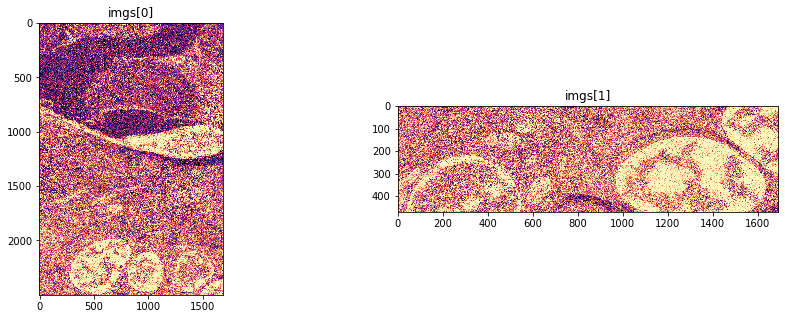

In [11]:
# Display up to first 3 images in the dataset
_,axs = plt.subplots(ncols=min(3,len(imgs)),figsize=[15,5])
for t in range(min(3,len(imgs))):
  axs[t].imshow(imgs[t][0,...,0], cmap='magma')
  axs[t].set_title('imgs['+str(t)+']')
plt.show()

### Generating Training and Validation datasets 
---
Notes by `N2V` authors:
> - We will use the first image to extract training patches and store them as `X`
> - We will use the second (_or last_) image to extract validation patches.
>  - Patches are created so they do not overlap.
>  - Non-overlapping patches would also allow us to split them into a training and validation set per image.
> - This might be an interesting alternative to the split we performed above.
> _(Note: this is not the case if you specify a number of patches. See the docstring for details!)_


In [12]:
X = datagen.generate_patches_from_list( imgs[:1], shape=(64,64))
X_val = datagen.generate_patches_from_list(imgs[-1:], shape=(64,64))
# it won't hurt to check the shape of your variables
# here's how you do it, is it what you expected the shape(s) to be?!
print('\nDatasets:\n\tX    :{}\n\tX_val:{}'.format(
    X.shape, X_val.shape))

Generated patches: (8112, 64, 64, 1)
Generated patches: (1456, 64, 64, 1)

Datasets:
	X    :(8112, 64, 64, 1)
	X_val:(1456, 64, 64, 1)


---
**Notes on cropping ROIs**<br><br>
If you are using your own dataset you might want to crop your images for training dataset so that you have representative images of your "signal". If your dataset is dominated by background signal images, `N2V` qualitatively performs similarly to gaussian filters (I'm assuming you don't want that).

For cropping your images use this example code below

```python
X = datagen.generate_patches_from_list(
  [x[:,y_min:y_max,x_min:x_max,:] for x in imgs[:n_frames]], shape=(64,64)  )
```
here 
```python
[x for x in imgs[:n_frames]]
```
generates list of elements from first `n_frames` of `imgs` list (or any iterable `imgs` with length $\geq$ `n_frames`), and 
```python
x[:,y_min:y_max,x_min:x_max,:]
```
makes sure that only the region (with your signal) within $[y_{min}, y_{max}]$ AND $[x_{min}, x_{max}]$ is passed on to `datagen.generate_patches_from_list( )`, which generates image patches with given shapes (e.g. `shape=(64,64)`) and stores them as `X` (this is your training dataset). If you want to use whole images for training dataset (this is what this `N2V` example is doing), you can just select subset of the elements from `imgs` list with __`imgs[:n_frames]`__, e.g. to select 1st frame use
```python
X = datagen.generate_patches_from_list( imgs[:1], shape=(64,64))
```
---

In [0]:
#@markdown *Just in case you don't know how to access the docstring of a method:* {display-mode: "form"}
#@markdown <br><br>run this command: __`datagen.generate_patches_from_list?`__
#@markdown <br>
#@markdown (_try running this cell to see what happens when you execute the command above_)
datagen.generate_patches_from_list?

### Let's look at a pair of our training and validation patches.

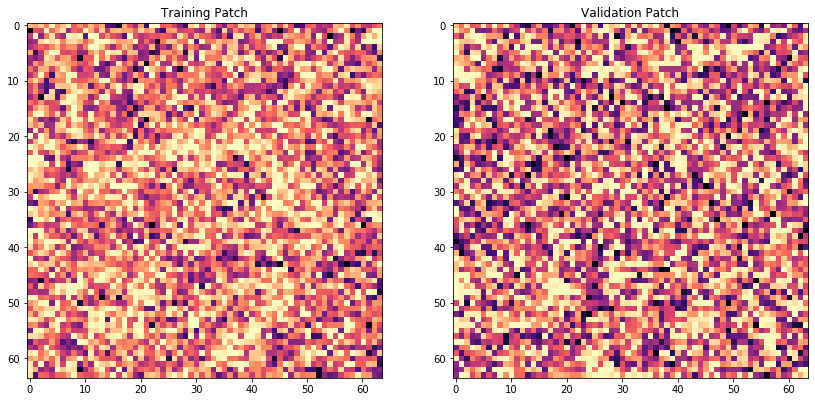

In [14]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

## Model: Configure the Model Hyperparameters, and Plot Model's Graph

Notes from `N2V` authors:
>>Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

Notes on input data normalization (**important!**):
>>When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

For the options decribed below, start with recommended (default) settings and change them (one-at-a-time) for tuning:
>>Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size.<br>
>Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation
>>
>> For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 64 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.
>>
>> For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

From `N2V`authors:
><font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 10 and <code>train_steps_per_epoch</code> to only 10. <br>For better results we suggest values of 100, and a few dozen, respectively.

Although above the authors recommend (2-3)x10 `train_steps_per_epoch`, it is better to keep it close to 10 (~10-15), at least when you are still tuning the hyperparameters, and increase the number of epochs (`train_epochs`) instead. This will provided more useful information about the training and a faster update of the loss values for you to see and to act upon (e.g. stop the training, and to tune hyperparameters). 

---
Hyperparameters and terms:
- `loss`: loss function evaluated on dataset (scalar values). Loss function (loss) describes performance of the model on given datasets, e.g. training and validation datasets (here we are trying to minimize loss using gradient descent). The default loss for `N2V` is __`mse`__ (mean squared error, i.e. mean over all examples in the dataset of the L2-norm squared of the difference between predicted and ground truth images) $\frac{1}{number\ of\ examples}\sum||Y_{pred}-Y_{ground\ truth}||^2_2$
- `lr` : learning rate (dictates how far you move along the gradient each training step/iteration)
- `train_steps_per_epoch`: number of iterations per epoch (each iteration updates the model to minimize loss)
- `train_epochs`: total number of epochs (total number of training steps=`train_steps_per_epoch`x`train_epochs`).
- `batch_norm`: enables/disables batch normalization (BN). BN normalizes activation in the convnet model which reduces cases of exploding and zero gradient. See original [batch normalization paper](https://arxiv.org/abs/1502.03167) for details.
-  `train_batch_size`: batch size, number of examples (patches) used in each training step/iteration.

In [0]:
# param-s that start with "n2v_" define how the input pixels are perturbed
# E.g. `n2v_manipulator`, `n2v_neighborhood_radius`, etc.
# You can increase "train_epochs" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=10,train_epochs=10, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.6, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# # Let's look at the parameters stored in the config-object.
# vars(config)

### Create and name your `N2V` model
---

In [18]:
#@markdown Enable/disable __overwriting__ the "model" files (and folders)
Over_Write = True #@param {type:"boolean"}
if Over_Write:
  try:
    model_dir_path = '{}/{}'.format(basedir,model_name)
    print(model_dir_path,' exists. Deleting it to overwrite.')
    if os.path.isdir(model_dir_path):
      !rm -dr $model_dir_path
  except NameError:
    print('Model base directory or model file name are *not* defined')


#@markdown Name your model (a name is used to identify the model)
model_name = "n2v_2D" #@param ["n2v_2D"] {allow-input: true}
#@markdown Choose the base directory in which our model will live (hopefully, a happy, and long life)
basedir = 'models' #@param ["models"] {allow-input: true}
#@markdown <br>(This cell also __checks__ whether directory with the model already exists, and __deletes it__ in order to avoid duplicates)<br>

models/n2v_2D  exists. Deleting it to overwrite.


In [19]:
# We are now creating our network model.
print('Creating network model with a given `config`')
model = N2V(config, model_name, basedir=basedir)

Creating network model with a given `config`


### Do you want to plot your model?... O.K. fine. (sing it)

In [0]:
# from IPython.display import SVG
# from keras.utils import model_to_dot
# # Create SVG representation of the model's graph and write it to "model.svg" file (you can download it)
# model_svg_bytes = model_to_dot(model.keras_model,dpi=60,show_shapes=True).create(prog='dot', format='svg')
# with open(r"model.svg","wb") as svg_file:
#   svg_file.write(model_svg_bytes)
# SVG(model_svg_bytes)

# # Or save the graph as a PNG using keras.utils.plot_model:
# # from keras.utils import plot_model
# # plot_model(model.keras_model, to_file='model.png',dpi=96,show_shapes=True)

## Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [0]:
#@title Run tensorboard (use this cell to monitor training process){display-mode: "form"}
#@markdown ---
#@markdown Enable the Tensorboard ?
Run_Tensorboard = False #@param {type:"boolean"}

if Run_Tensorboard:
  %load_ext tensorboard
  %tensorboard --logdir=.

#@markdown <br>Use " `!ps -A|grep tensorboard` " to check its process ID (if you want to kill it)

In [23]:
# We are ready to start training now.
history = model.train(X, X_val)


65 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1456/1456 [00:03<00:00, 383.50it/s]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/10
10/10 [==============================] - 7s 676ms/step - loss: 1.4121 - n2v_mse: 1.4121 - n2v_abs: 0.9578 - val_loss: 0.9284 - val_n2v_mse: 0.9284 - val_n2v_abs: 0.7790

Epoch 2/10
10/10 [==============================] - 2s 162ms/step - loss: 0.9522 - n2v_mse: 0.9522 - n2v_abs: 0.7956 - val_loss: 0.8023 - val_n2v_mse: 0.8023 - val_n2v_abs: 0.7018
Epoch 3/10
10/10 [==============================] - 3s 309ms/step - loss: 0.7415 - n2v_mse: 0.7415 - n2v_abs: 0.7041 - val_loss: 0.7523 - val_n2v_mse: 0.7523 - val_n2v_abs: 0.6669
Epoch 4/10
10/10 [==============================] - 3s 325ms/step - loss: 0.6605 - n2v_mse

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


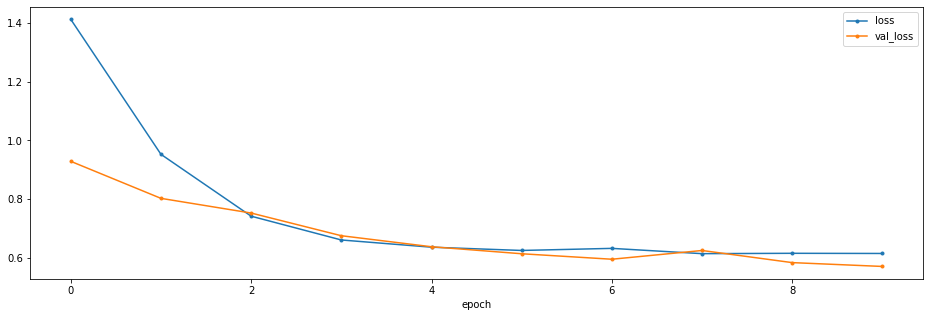

In [24]:
#@title Plotting the training and validation loss for each "step" of training process. {display-mode: "form"}
#@markdown ---
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

### Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [0]:
#@title Use this command to export N2V model to be used in Fiji: {display-mode: "form"}
#@markdown ---
SAVE_FIJI = False #@param {type:"boolean"}
if SAVE_FIJI:
  model.export_TF()
#@markdown (saved in the same directory as the model, i.e. in the "__`basedir`__")
#
#@markdown ---

# Noise2Void - 2D Example for SEM data: Prediction Notebook (2/2)

## Import the dependencies (You must run the cell below!)
---
- This cell was kept after it was copied from "prediction" notebook in the original N2V repository.
- Some imports are redundant, but this allows all the cells in the "Prediction notebook" to be run independently from the cells above.


In [0]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

## Load a Previously Trained Model and Its Weights

In [0]:
#@markdown Provide **location** and **name** of your model {display-mode: "form"}
#@markdown <br>(defaults: {"n2v_2D" and "models"} )
model_name = "n2v_2D" #@param ["n2v_2D"] {allow-input: true}
basedir = 'models' #@param ["models"] {allow-input: true}

In [35]:
# Load weights with the lowest val_loss a.k.a. "best" weights
# by creating a new N2V-object without providing a `config`
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


- by default, this loads the weights with the lowest validation loss during training
- To load the latest computed weights use (after executing the command above)
> `model.load_weights('weights_last.h5')`

In [0]:
#@markdown Enable/Disable loading "weights_last" below (default: __`False`__): {display-mode: "form"}
LOAD_weights_last = False #@param {type:"boolean"}
if LOAD_weights_last:
  model.load_weights('weights_last.h5')
# In case you do not want to load the weights that lead to lowest validation loss during 
# training but the latest computed weights, you can execute the following line:
# model.load_weights('weights_last.h5')
#@markdown ---

Here we will simply use the same data as during training and denoise it using our network.

## Load Test Dataset and Predict the De-noised Results
---
Default location for the training and validation (or test) examples are "`data/train.tif`" and "`data/validation.tif`".

Optionally, provide location of your data below:



In [0]:
#@markdown Location for the __training__ data: {display-mode: "form"}
training_data_ = "data/train.tif" #@param ["data/train.tif"] {allow-input: true}
#@markdown Location of the __validation__ data.
# We load and process the data we previously used for validation.
validation_data_ = "data/validation.tif" #@param ["data/validation.tif"] {allow-input: true}

- We load the data we want to process with __`imread`__
- (from tifffile, alter.-ly use scikit-image)
>`input_train = imread(training_data_)`
- Then, use __`model.predict`__ to de-noise the input image(s)
- `model.predict` can process large images as multiple "tiles". The parameter 'n_tiles' can be used if images are too large for the GPU memory.

In [0]:
# read training image(s)
input_train = imread(training_data_)
# read validation(or testing images)
input_val = imread(validation_data_)

In [42]:
#@title Calculate De-noised Images {display-mode: "form"}
#@markdown `pred_train = model.predict(input_train, axes='YX')`

#@markdown `pred_val = model.predict(input_val, axes='YX')`
#   Here we process the data.
#   The parameter 'n_tiles' can be used if images are to big for the GPU memory.
#   If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
#   This can take longer.
if input_train.ndim==3:
  # used when inputs are frames
  print('\nWarning: input_train is tif stack, predictions will be a list of frames.')
  pred_train = [model.predict(input_train[t,...], axes='YX', n_tiles=(2,1)) 
  for t in range(input_train.shape[0])]
  print('\npred_train {} frames:\n'.format(len(pred_train)),
        [pred_train[k].shape for k in range(min(3,len(pred_train)))],
        '...' if len(pred_val)>3 else '')
else:
  # for single input image:
  pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))
  print('\npred_train:\n',pred_train.shape)


if input_val.ndim==3:
  # used when inputs are frames
  print('\nWarning: input_val is tif stack, predictions will be a list of frames.')
  pred_val = [model.predict(input_val[t,...], axes='YX') 
  for t in range(input_val.shape[0])]
  print('\npred_val {} frames:\n'.format(len(pred_val)),
        [pred_val[k].shape for k in range(min(3,len(pred_val)))],
        '...' if len(pred_val)>3 else '')
else:
  # for single input image:
  pred_val = model.predict(input_val, axes='YX')
  print('\npred_val:\n',pred_val.shape)

100%|██████████| 2/2 [00:00<00:00,  8.86it/s]


pred_train:
 (2500, 1690)

pred_val:
 (471, 1690)


## Show results on training data...

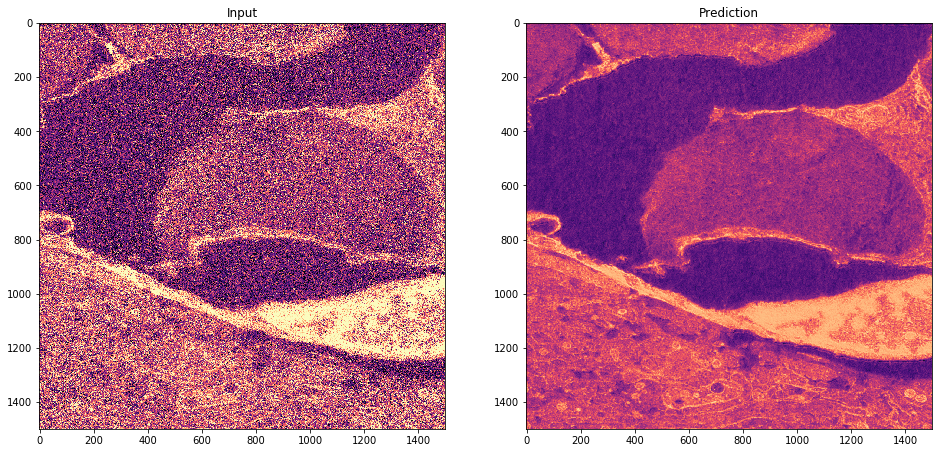

In [41]:
#@title Let's look at the "training set" results. {display-mode: "form"}
#@markdown `plt.imshow( input_train )`
#@markdown and
#@markdown `plt.imshow( pred_train )`

if input_train.ndim==3:
  x_input = input_train[-1,...]
  y_train = pred_train[-1]
else:
  x_input = input_train[:1500:,:1500] #for examples that come with n2v
  y_train = pred_train[:1500,:1500]
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x_input,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(y_train,cmap="magma")
plt.title('Prediction');

## Show results on validation data...

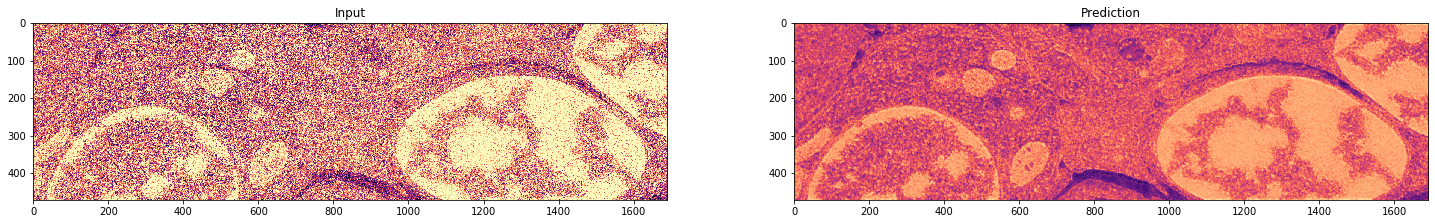

In [43]:
#@title Let's look at the "validation set" results. {display-mode: "form"}
#@markdown `plt.imshow( input_val )` and `plt.imshow( pred_val )`
if input_val.ndim==3:
  x_val = input_val[-1,...]
  y_val = pred_val[-1]
else:
  x_val = input_val #for examples that come with n2v
  y_val = pred_val
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.imshow(x_val,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(y_val,cmap="magma")
plt.title('Prediction');


## Save Results

For saving the de-noised prediction use "__`save_tiff_imagej_compatible( )`__" e.g.:
```python
save_tiff_imagej_compatible('pred_train.tif', pred_train, axes='YX')
save_tiff_imagej_compatible('pred_validation.tif', pred_val, axes='YX')
```
- Save it to your google drive, or in the local folder (__don't forget to copy it__)

In [0]:
# save_tiff_imagej_compatible('pred_train.tif', pred_train, axes='YX') # use TYX for tif stacks
# save_tiff_imagej_compatible('pred_validation.tif', pred_val, axes='YX') # same here